In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install sentence-transformers
import torch
import pandas as pd
from torch_geometric.data import HeteroData, download_url, extract_zip
from torch_geometric.transforms import ToUndirected, RandomLinkSplit

from sklearn import preprocessing
import torch
import pandas as pd
import numpy as np
# from torch_geometric.data import Data
import os.path as osp
import inspect
import sys
import os
from sklearn.feature_extraction.text import CountVectorizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.nn import Parameter

# Helper functions for visualization.
%matplotlib inline

clinical = pd.read_csv('data/clinical_data_breast_cancer.csv', index_col=0)
proteomes_orig = pd.read_csv('data/77_cancer_proteomes_CPTAC_itraq.csv')
PAM50 = pd.read_csv('data/PAM50_proteins.csv')
proteomes = proteomes_orig.drop(['gene_symbol','gene_name'], axis=1)
clinical.index = clinical.index.to_series().apply(lambda title : title.split('CGA-')[1])
proteomes.rename(columns = proteomes.columns.to_series().apply(lambda title: title.split('.')[0]), inplace=True)

#Transpose and organize proteomes data
proteomes = proteomes.transpose()
proteomes.columns =  proteomes.iloc[0]
proteomes.drop('RefSeq_accession_number', axis=0, inplace=True)

#Convert gender to numbers
def num_gender(gender):
    if gender == 'MALE':
        return 0
    elif gender == 'FEMALE':
        return 1
    else:
        return float('NaN')

clinical['Gender'] = clinical['Gender'].apply(lambda gender: num_gender(gender))

#Convert status to numbers
def num_status(status):
    if status == 'Negative':
        return 0
    elif status == 'Positive':
        return 1
    else:
        return

clinical['ER Status'] = clinical['ER Status'].apply(lambda status: num_status(status))
clinical['PR Status'] = clinical['PR Status'].apply(lambda status: num_status(status))
clinical['HER2 Final Status'] = clinical['HER2 Final Status'].apply(lambda status: num_status(status))

#Convert tumor, node, metastasis to numbers
clinical['Tumor'] = clinical['Tumor'].apply(lambda tumor: tumor.split('T')[1])
clinical['Node'] = clinical['Node'].apply(lambda tumor: tumor.split('N')[1])
clinical['Metastasis'] = clinical['Metastasis'].apply(lambda tumor: tumor.split('M')[1])
#Remove unused columns
clinical.drop('Tumor--T1 Coded', axis=1, inplace=True)
clinical.drop('Metastasis-Coded', axis=1, inplace=True)
clinical.drop('Node-Coded', axis=1, inplace=True)

#Merge clinical data with proteomes data
datasetPrim = clinical.merge(proteomes, left_index=True,right_index=True)

datasetPrim

You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.


,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Node,Metastasis,AJCC Stage,Converted Stage,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
A2-A0CM,1,40,0.0,0,0.0,2,0,0,Stage IIA,Stage IIA,...,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2-A0D2,1,45,0.0,0,0.0,2,0,0,Stage IIB,Stage IIA,...,0.919136,-1.648856,0.832649,NaN,-8.324969,-4.679219,NaN,-1.10665,NaN,-6.941181
A2-A0EQ,1,64,0.0,0,1.0,2,0,0,Stage IIA,Stage IIA,...,-0.801685,NaN,NaN,3.80231,-6.373934,-1.12316,NaN,NaN,NaN,NaN
A2-A0EV,1,80,1.0,1,0.0,1,0,0,Stage IA,Stage I,...,-4.966177,-1.471027,NaN,-0.474013,-12.278546,-10.337729,-0.653251,NaN,NaN,NaN
A2-A0EX,1,46,1.0,1,0.0,3,0,0,Stage IIB,Stage IIB,...,1.45149,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C8-A138,1,54,1.0,0,1.0,2,2,0,Stage III,Stage IIIA,...,-3.250913,1.711825,-0.248402,NaN,4.707022,4.107251,-3.20337,1.971481,NaN,NaN
D8-A142,1,74,0.0,0,0.0,3,0,0,Stage IIB,Stage IIB,...,-5.107629,-0.97598,NaN,2.508629,-12.33711,-9.54653,-4.066584,NaN,NaN,NaN
E2-A154,1,68,1.0,1,0.0,1,0,0,Stage I,Stage I,...,-3.386203,-2.328692,-2.806642,NaN,-4.733495,-9.584499,-4.786183,-3.103949,NaN,NaN
E2-A158,1,43,0.0,0,0.0,1,1,0,Stage IIA,Stage IIA,...,-0.638364,0.051811,2.509998,7.067839,NaN,0.378972,NaN,NaN,0.665797,NaN


In [2]:
datasetPrim.columns[26:]

Index(['NP_958782', 'NP_958785', 'NP_958786', 'NP_000436', 'NP_958781',
       'NP_958780', 'NP_958783', 'NP_958784', 'NP_112598', 'NP_001611',
       ...
       'NP_001193600', 'NP_061134', 'NP_932347', 'NP_003593', 'NP_997203',
       'NP_001191293', 'NP_775791', 'NP_004065', 'NP_068752', 'NP_219494'],
      dtype='object', length=12553)

In [3]:
# noNaProteasomesColumns= np.array(datasetPrim.dropna(axis=1).columns[24:300])
# noNaProteasomesColumns= np.array(datasetPrim.dropna(axis=1).columns[150:350])
withNaProteasomesColumns = datasetPrim.columns[26:300]
# columnsOfIntrest = np.insert(noNaProteasomesColumns, 0, 'Tumor', axis=0)
dataset=datasetPrim[withNaProteasomesColumns]
labels = np.array(datasetPrim['Tumor']).astype(int)
labels

array([2, 2, 2, 1, 3, 2, 2, 1, 1, 3, 2, 3, 1, 2, 2, 2, 2, 3, 4, 3, 2, 4,
       4, 3, 2, 3, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 1, 1, 2])

In [4]:
import numpy as np


def create_edge_attr(df):
    nrow, ncol = df.shape # we just get number of rows and columns
    edge_attr = [] #initialization
    #seems that in this loop we basically flatten the matrix
    for i in range(nrow): #iterating all rows
        for j in range(ncol):
            if(~np.isnan(df.iloc[i,j])):
                edge_attr.append([float(df.iloc[i,j])])# we assume all of the entries to be float
    edge_attr = edge_attr + edge_attr# here we are basically we are doing vcat - so maybe we have two directional edges?
    return edge_attr
#
# ([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 4, 5, 3, 4, 5, 3, 4, 5],
#  [3, 4, 5, 3, 4, 5, 3, 4, 5, 0, 0, 0, 1, 1, 1, 2, 2, 2])

def create_edge(df):
    n_row, n_col = df.shape
    edge_start = []
    edge_end = []
    for x in range(n_row):
        for y in range(n_col):
            if(~np.isnan(df.iloc[x,y])):
                edge_start.append(x)
                edge_end.append(n_row+y)
    # for x in range(n_row):
    #     edge_start = edge_start + [x] * n_col # obj
    #     edge_end = edge_end + list(n_row+np.arange(n_col)) # att
    #     if(x==n_row-1):
    #       pass
          #print(edge_start)
    edge_start_new = edge_start + edge_end
    edge_end_new = edge_end + edge_start
    return (edge_start_new, edge_end_new)

def save_mask(length,true_rate,log_dir,seed):
    np.random.seed(seed)
    mask = np.random.rand(length) < true_rate
    np.save(osp.join(log_dir,'len'+str(length)+'rate'+str(true_rate)+'seed'+str(seed)),mask)
    return mask
#so this seems to be dropout mechanism ...
def mask_edge(edge_index,edge_attr,mask,remove_edge):
    edge_index = edge_index.clone().detach()
    edge_attr = edge_attr.clone().detach()
    if remove_edge:
        edge_index = edge_index[:,mask]
        edge_attr = edge_attr[mask]
    else:
        edge_attr[~mask] = 0.
    return edge_index, edge_attr

def get_known_mask(known_prob, edge_num):
    known_mask = (torch.FloatTensor(edge_num, 1).uniform_() < known_prob).view(-1)
    return known_mask

# basically it will return ones matrix of size  the same as frame plus hcat with identity matrix of the same size
def create_node(df): # # onehot feature node, sampling of single node
        nrow, ncol = df.shape  # we just get number of rows and columns
        feature_ind = np.array(range(ncol)) #getting indicies for iteration I suppose
        feature_node = np.zeros((ncol,ncol))
        feature_node[np.arange(ncol), feature_ind] = 1
        sample_node = [[1]*ncol for i in range(nrow)]
        node = sample_node + feature_node.tolist()
        return node
# def create_node(df):
#         nrow, ncol = df.shape  # we just get number of rows and columns
#         return np.arange(ncol*nrow)


In [5]:
datasetPrimMini = datasetPrim.iloc[71:74,71:74]
datasetPrimMini

,NP_001094891,NP_057323,NP_002465
C8-A131,2.585656,NaN,-2.1787
C8-A131,NaN,NaN,-1.090145
C8-A134,NaN,NaN,4.424509


In [6]:
create_edge(datasetPrimMini)
# ([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 4, 5, 3, 4, 5, 3, 4, 5],
#  [3, 4, 5, 3, 4, 5, 3, 4, 5, 0, 0, 0, 1, 1, 1, 2, 2, 2])

([0, 0, 1, 2, 3, 5, 5, 5], [3, 5, 5, 5, 0, 0, 1, 2])

In [7]:
from torch_geometric.data import Data


def get_data(df_X, df_y, train_edge_prob=0.7, split_sample_ratio=0., split_by='y', train_y_prob=0.7, seed=0, normalize=True):

    # if len(df_y.shape)==1:
    #     df_y = df_y.to_numpy()
    # elif len(df_y.shape)==2:
    #     df_y = df_y[0].to_numpy()

    if normalize:
        x = df_X.values
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df_X = pd.DataFrame(x_scaled)

    edge_start, edge_end = create_edge(df_X)
    edge_index = torch.tensor([edge_start, edge_end], dtype=int)
    edge_attr = torch.tensor(create_edge_attr(df_X), dtype=torch.float)
    node_init = create_node(df_X)

    x = torch.tensor(node_init, dtype=torch.float)
    y = torch.tensor(df_y, dtype=torch.float)

    torch.manual_seed(seed)

    train_edge_mask = get_known_mask(train_edge_prob, int(edge_attr.shape[0]/2))
    double_train_edge_mask = torch.cat((train_edge_mask, train_edge_mask), dim=0)

    #mask edges based on the generated train_edge_mask
    #train_edge_index is known, test_edge_index in unknwon, i.e. missing
    train_edge_index, train_edge_attr = mask_edge(edge_index, edge_attr,
                                                double_train_edge_mask, True)
    train_labels = train_edge_attr[:int(train_edge_attr.shape[0]/2),0]
    test_edge_index, test_edge_attr = mask_edge(edge_index, edge_attr,
                                                ~double_train_edge_mask, True)
    test_labels = test_edge_attr[:int(test_edge_attr.shape[0]/2),0]
    #mask the y-values during training, i.e. how we split the training and test sets
    train_y_mask = get_known_mask(train_y_prob, y.shape[0])
    test_y_mask = ~train_y_mask

    data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr,
            train_y_mask=train_y_mask, test_y_mask=test_y_mask,
            train_edge_index=train_edge_index,train_edge_attr=train_edge_attr,
            train_edge_mask=train_edge_mask,train_labels=train_labels,
            test_edge_index=test_edge_index,test_edge_attr=test_edge_attr,
            test_edge_mask=~train_edge_mask,test_labels=test_labels,
            df_X=df_X,df_y=df_y,
            edge_attr_dim=train_edge_attr.shape[-1],
            user_num=df_X.shape[0]
            )
    return data

c:\users\1\pycharmprojects\pythonproject4\venv\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\users\1\pycharmprojects\pythonproject4\venv\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


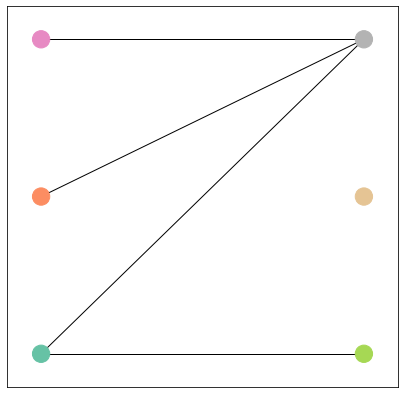

In [8]:
from torch_geometric.utils import to_networkx
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    # nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,pos = nx.drawing.layout.bipartite_layout(G, B_first_partition_nodes),

    nx.draw_networkx(G,  with_labels=False,pos = nx.drawing.layout.bipartite_layout(G,np.arange(3) ),
                     node_color=color, cmap="Set2")
    plt.show()
pyTorchDatasetMini = get_data(datasetPrimMini,datasetPrimMini.iloc[1,:] )

G = to_networkx(pyTorchDatasetMini, to_undirected=True)
visualize_graph(G, color=np.arange(6))

In [9]:
pyTorchDataset= get_data(dataset,labels)
pyTorchDataset

Data(x=[354, 274], edge_index=[2, 42736], edge_attr=[42736, 1], y=[80], train_y_mask=[80], test_y_mask=[80], train_edge_index=[2, 29870], train_edge_attr=[29870, 1], train_edge_mask=[21368], train_labels=[14935], test_edge_index=[2, 12866], test_edge_attr=[12866, 1], test_edge_mask=[21368], test_labels=[6433], df_X=         0         1         2         3         4         5         6    \
0   0.558300  0.559362  0.560367  0.555202  0.557409  0.560367  0.559935   
1   0.436100  0.434636  0.435632  0.430973  0.434553  0.434930  0.434594   
2   0.219637  0.216536  0.216943  0.214082  0.217015  0.216943  0.216776   
3   0.509409  0.512487  0.512741  0.507056  0.512203  0.512741  0.512345   
4   0.664754  0.664634  0.664016  0.660143  0.665539  0.664016  0.663503   
..       ...       ...       ...       ...       ...       ...       ...   
75  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
76  0.527574  0.527198  0.527444  0.523153  0.526877  0.527444  0.527037   

In [10]:
pyTorchDataset.node_stores

[{'x': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]), 'edge_index': tensor([[  0,   0,   0,  ..., 351, 352, 353],
         [ 80,  81,  82,  ...,  79,  79,  79]]), 'edge_attr': tensor([[0.5583],
         [0.5594],
         [0.5604],
         ...,
         [0.4803],
         [0.2763],
         [0.7648]]), 'y': tensor([2., 2., 2., 1., 3., 2., 2., 1., 1., 3., 2., 3., 1., 2., 2., 2., 2., 3.,
         4., 3., 2., 4., 4., 3., 2., 3., 4., 2., 4., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 1., 1., 3., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2.,
         1., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2.,
         2., 2., 2., 2., 3., 1., 1., 2.]), 'train_y_mask': tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True,
         False, 

# Training

In [11]:
import numpy as np
import torch
import torch.nn.functional as F
import pickle
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch.optim as optim
import numpy as np
import os.path as osp
import torch
import subprocess
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops

from torch.nn.init import xavier_uniform_, zeros_

import torch.nn as nn
import torch.nn.functional as F


In [12]:
#utils
def np_random(seed=None):
    rng = np.random.RandomState()
    rng.seed(seed)
    return rng

def get_activation(activation):
    if activation == 'relu':
        return torch.nn.ReLU()
    elif activation == 'prelu':
        return torch.nn.PReLU()
    elif activation == 'tanh':
        return torch.nn.Tanh()
    elif (activation is None) or (activation == 'none'):
        return torch.nn.Identity()
    else:
        raise NotImplementedError

def one_hot(batch,depth):
    ones = torch.sparse.torch.eye(depth)
    return ones.index_select(0,torch.tensor(batch,dtype=int))

def soft_one_hot(batch,depth):
    batch = torch.tensor(batch)
    encodings = torch.zeros((batch.shape[0],depth))
    for i,x in enumerate(batch):
        for r in range(depth):
            encodings[i,r] = torch.exp(-((x-float(r))/float(depth))**2)
        encodings[i,:] = encodings[i,:]/torch.sum(encodings[i,:])
    return encodings

def construct_missing_X_from_mask(train_mask, df):
    nrow, ncol = df.shape
    data_incomplete = np.zeros((nrow, ncol))
    data_complete = np.zeros((nrow, ncol))
    train_mask = train_mask.reshape(nrow, ncol)
    for i in range(nrow):
        for j in range(ncol):
            data_complete[i,j] = df.iloc[i,j]
            if train_mask[i,j]:
                data_incomplete[i,j] = df.iloc[i,j]
            else:
                data_incomplete[i,j] = np.NaN
    return data_complete, data_incomplete

def construct_missing_X_from_edge_index(train_edge_index, df):
    nrow, ncol = df.shape
    data_incomplete = np.zeros((nrow, ncol))
    data_complete = np.zeros((nrow, ncol))
    train_edge_list = torch.transpose(train_edge_index,1,0).numpy()
    train_edge_list = list(map(tuple,[*train_edge_list]))
    for i in range(nrow):
        for j in range(ncol):
            data_complete[i,j] = df.iloc[i,j]
            if (i,j) in train_edge_list:
                data_incomplete[i,j] = df.iloc[i,j]
            else:
                data_incomplete[i,j] = np.NaN
    return data_complete, data_incomplete

# get gpu usage
def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = np.array([int(x) for x in result.strip().split('\n')])
    # gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory

def auto_select_gpu(memory_threshold = 7000, smooth_ratio=200, strategy='greedy'):
    gpu_memory_raw = get_gpu_memory_map() + 10
    if strategy=='random':
        gpu_memory = gpu_memory_raw/smooth_ratio
        gpu_memory = gpu_memory.sum() / (gpu_memory+10)
        gpu_memory[gpu_memory_raw>memory_threshold] = 0
        gpu_prob = gpu_memory / gpu_memory.sum()
        cuda = str(np.random.choice(len(gpu_prob), p=gpu_prob))
        print('GPU select prob: {}, Select GPU {}'.format(gpu_prob, cuda))
    elif strategy == 'greedy':
        cuda = np.argmin(gpu_memory_raw)
        print('GPU mem: {}, Select GPU {}'.format(gpu_memory_raw[cuda], cuda))
    return cuda


In [13]:
#egSage
#
# class EGraphSage(MessagePassing):
#     """Non-minibatch version of GraphSage."""
#     def __init__(self, in_channels, out_channels,
#                  edge_channels, activation, edge_mode,
#                  normalize_emb,
#                  aggr):
#         super(EGraphSage, self).__init__(aggr=aggr)
#
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.edge_channels = edge_channels
#         self.edge_mode = edge_mode
#
#         if edge_mode == 0:
#             self.message_lin = nn.Linear(in_channels, out_channels)
#             self.attention_lin = nn.Linear(2*in_channels+edge_channels, 1)
#         elif edge_mode == 1:
#             self.message_lin = nn.Linear(in_channels+edge_channels, out_channels)
#         elif edge_mode == 2:
#             self.message_lin = nn.Linear(2*in_channels+edge_channels, out_channels)
#         elif edge_mode == 3:
#             self.message_lin = nn.Sequential(
#                     nn.Linear(2*in_channels+edge_channels, out_channels),
#                     get_activation(activation),
#                     nn.Linear(out_channels, out_channels),
#                     )
#         elif edge_mode == 4:
#             self.message_lin = nn.Linear(in_channels, out_channels*edge_channels)
#         elif edge_mode == 5:
#             self.message_lin = nn.Linear(2*in_channels, out_channels*edge_channels)
#
#         self.agg_lin = nn.Linear(in_channels+out_channels, out_channels)
#
#         self.message_activation = get_activation(activation)
#         self.update_activation = get_activation(activation)
#         self.normalize_emb = normalize_emb
#
#     def forward(self, x, edge_attr, edge_index):
#         num_nodes = x.size(0)
#         # x has shape [N, in_channels]
#         # edge_index has shape [2, E]
#
#         return self.propagate(edge_index, x=x, edge_attr=edge_attr, size=(num_nodes, num_nodes))
#
#     def message(self, x_i, x_j, edge_attr, edge_index, size):
#         # x_j has shape [E, in_channels]
#         # edge_index has shape [2, E]
#         if self.edge_mode == 0:
#             attention = self.attention_lin(torch.cat((x_i,x_j, edge_attr),dim=-1))
#             m_j = attention * self.message_activation(self.message_lin(x_j))
#         elif self.edge_mode == 1:
#             m_j = torch.cat((x_j, edge_attr),dim=-1)
#             m_j = self.message_activation(self.message_lin(m_j))
#         elif self.edge_mode == 2 or self.edge_mode == 3:
#             m_j = torch.cat((x_i,x_j, edge_attr),dim=-1)
#             m_j = self.message_activation(self.message_lin(m_j))
#         elif self.edge_mode == 4:
#             E = x_j.shape[0]
#             w = self.message_lin(x_j)
#             w = self.message_activation(w)
#             w = torch.reshape(w, (E,self.out_channels,self.edge_channels))
#             m_j = torch.bmm(w, edge_attr.unsqueeze(-1)).squeeze(-1)
#         elif self.edge_mode == 5:
#             E = x_j.shape[0]
#             w = self.message_lin(torch.cat((x_i,x_j),dim=-1))
#             w = self.message_activation(w)
#             w = torch.reshape(w, (E,self.out_channels,self.edge_channels))
#             m_j = torch.bmm(w, edge_attr.unsqueeze(-1)).squeeze(-1)
#         return m_j
#
#     def update(self, aggr_out, x):
#         # aggr_out has shape [N, out_channels]
#         # x has shape [N, in_channels]
#         aggr_out = self.update_activation(self.agg_lin(torch.cat((aggr_out, x),dim=-1)))
#         if self.normalize_emb:
#             aggr_out = F.normalize(aggr_out, p=2, dim=-1)
#         return aggr_out


In [14]:
from torch import Tensor
from torch_geometric.nn.models.basic_gnn import BasicGNN
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size

from torch import Tensor
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear



class EGraphSage(MessagePassing):
    r"""The GraphSAGE operator from the `"Inductive Representation Learning on
    Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j
    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        normalize (bool, optional): If set to :obj:`True`, output features
            will be :math:`\ell_2`-normalized, *i.e.*,
            :math:`\frac{\mathbf{x}^{\prime}_i}
            {\| \mathbf{x}^{\prime}_i \|_2}`.
            (default: :obj:`False`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels, out_channels,
                 edge_channels, activation, edge_mode,
                 normalize_emb,
                 aggr):

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize_emb
        self.root_weight = True
        self.message_lin = nn.Linear(in_channels+edge_channels, out_channels)

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=True)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out

    def message(self, x_j: Tensor) -> Tensor:
        return x_j


    def message(self, x_i, x_j, edge_attr, edge_index, size):
        # x_j has shape [E, in_channels]
        # edge_index has shape [2, E]
        if self.edge_mode == 0:
            attention = self.attention_lin(torch.cat((x_i,x_j, edge_attr),dim=-1))
            m_j = attention * self.message_activation(self.message_lin(x_j))
        elif self.edge_mode == 1:
            m_j = torch.cat((x_j, edge_attr),dim=-1)
            m_j = self.message_activation(self.message_lin(m_j))

    def message_and_aggregate(self, adj_t: SparseTensor,
                              x: OptPairTensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)


In [15]:
#gnn_model

def get_gnn(data, args):
    model_types = args.model_types.split('_')
    if args.norm_embs is None:
        norm_embs = [True,]*len(model_types)
    else:
        norm_embs = list(map(bool,map(int,args.norm_embs.split('_'))))
    if args.post_hiddens is None:
        post_hiddens = [args.node_dim]
    else:
        post_hiddens = list(map(int,args.post_hiddens.split('_')))
    print(model_types, norm_embs, post_hiddens)
    # build model
    model = GNNStack(data.num_node_features, data.edge_attr_dim,
                        args.node_dim, args.edge_dim, args.edge_mode,
                        model_types, args.dropout, args.gnn_activation,
                        args.concat_states, post_hiddens,
                        norm_embs, args.aggr)
    return model

class GNNStack(torch.nn.Module):
    def __init__(self,
                node_input_dim, edge_input_dim,
                node_dim, edge_dim, edge_mode,
                model_types, dropout, activation,
                concat_states, node_post_mlp_hiddens,
                normalize_embs, aggr
                ):
        super(GNNStack, self).__init__()
        self.dropout = dropout
        self.activation = activation
        self.concat_states = concat_states
        self.model_types = model_types
        self.gnn_layer_num = len(model_types)

        # convs
        self.convs = self.build_convs(node_input_dim, edge_input_dim,
                                    node_dim, edge_dim, edge_mode,
                                    model_types, normalize_embs, activation, aggr)

        # post node update
        if concat_states:
            self.node_post_mlp = self.build_node_post_mlp(int(node_dim*len(model_types)), int(node_dim*len(model_types)), node_post_mlp_hiddens, dropout, activation)
        else:
            self.node_post_mlp = self.build_node_post_mlp(node_dim, node_dim, node_post_mlp_hiddens, dropout, activation)

        self.edge_update_mlps = self.build_edge_update_mlps(node_dim, edge_input_dim, edge_dim, self.gnn_layer_num, activation)

    def build_node_post_mlp(self, input_dim, output_dim, hidden_dims, dropout, activation):
        if 0 in hidden_dims:
            return get_activation('none')
        else:
            layers = []
            for hidden_dim in hidden_dims:
                layer = nn.Sequential(
                            nn.Linear(input_dim, hidden_dim),
                            get_activation(activation),
                            nn.Dropout(dropout),
                            )
                layers.append(layer)
                input_dim = hidden_dim
            layer = nn.Linear(input_dim, output_dim)
            layers.append(layer)
            return nn.Sequential(*layers)

    def build_convs(self, node_input_dim, edge_input_dim,
                     node_dim, edge_dim, edge_mode,
                     model_types, normalize_embs, activation, aggr):
        convs = nn.ModuleList()
        conv = self.build_conv_model(model_types[0],node_input_dim,node_dim,
                                    edge_input_dim, edge_mode, normalize_embs[0], activation, aggr)
        convs.append(conv)
        for l in range(1,len(model_types)):
            conv = self.build_conv_model(model_types[l],node_dim, node_dim,
                                    edge_dim, edge_mode, normalize_embs[l], activation, aggr)
            convs.append(conv)
        return convs

    def build_conv_model(self, model_type, node_in_dim, node_out_dim, edge_dim, edge_mode, normalize_emb, activation, aggr):
        #print(model_type)
        if model_type == 'GCN':
            return pyg_nn.GCNConv(node_in_dim,node_out_dim)
        elif model_type == 'GraphSage':
            return pyg_nn.SAGEConv(node_in_dim,node_out_dim)
        elif model_type == 'GAT':
            return pyg_nn.GATConv(node_in_dim,node_out_dim)
        elif model_type == 'EGSAGE':
            return EGraphSage(node_in_dim,node_out_dim,edge_dim,activation,edge_mode,normalize_emb, aggr)

    def build_edge_update_mlps(self, node_dim, edge_input_dim, edge_dim, gnn_layer_num, activation):
        edge_update_mlps = nn.ModuleList()
        edge_update_mlp = nn.Sequential(
                nn.Linear(node_dim+node_dim+edge_input_dim,edge_dim),
                get_activation(activation),
                )
        edge_update_mlps.append(edge_update_mlp)
        for l in range(1,gnn_layer_num):
            edge_update_mlp = nn.Sequential(
                nn.Linear(node_dim+node_dim+edge_dim,edge_dim),
                get_activation(activation),
                )
            edge_update_mlps.append(edge_update_mlp)
        return edge_update_mlps

    def update_edge_attr(self, x, edge_attr, edge_index, mlp):
        x_i = x[edge_index[0],:]
        x_j = x[edge_index[1],:]
        edge_attr = mlp(torch.cat((x_i,x_j,edge_attr),dim=-1))
        return edge_attr

    def forward(self, x, edge_attr, edge_index):
        if self.concat_states:
            concat_x = []
        for l,(conv_name,conv) in enumerate(zip(self.model_types,self.convs)):
            # self.check_input(x,edge_attr,edge_index)
            if conv_name == 'EGCN' or conv_name == 'EGSAGE':
                x = conv(x, edge_attr, edge_index)
            else:
                x = conv(x, edge_index)
            if self.concat_states:
                concat_x.append(x)
            edge_attr = self.update_edge_attr(x, edge_attr, edge_index, self.edge_update_mlps[l])
            #print(edge_attr.shape)
        if self.concat_states:
            x = torch.cat(concat_x, 1)
        x = self.node_post_mlp(x)
        # self.check_input(x,edge_attr,edge_index)
        return x


In [16]:
#prediction model

class MLPNet(torch.nn.Module):
    def __init__(self,
         		input_dims, output_dim,
         		hidden_layer_sizes=(64,),
         		hidden_activation='relu',
         		output_activation=None,
                dropout=0.):
        super(MLPNet, self).__init__()

        layers = nn.ModuleList()

        input_dim = np.sum(input_dims)

        for layer_size in hidden_layer_sizes:
        	hidden_dim = layer_size
        	layer = nn.Sequential(
        				nn.Linear(input_dim, hidden_dim),
        				get_activation(hidden_activation),
        				nn.Dropout(dropout),
        				)
        	layers.append(layer)
        	input_dim = hidden_dim

        layer = nn.Sequential(
        				nn.Linear(input_dim, output_dim),
        				get_activation(output_activation),
        				)
       	layers.append(layer)
       	self.layers = layers

    def forward(self, inputs):
    	if torch.is_tensor(inputs):
    		inputs = [inputs]
    	input_var = torch.cat(inputs,-1)
    	for layer in self.layers:
    		input_var = layer(input_var)
    	return input_var

In [17]:
from torch_geometric.utils import f1_score
import argparse


def train_gnn_y(data, args, log_path, device=torch.device('cpu')):
    model = get_gnn(data, args).to(device)
    impute_hiddens = []
    if args.impute_hiddens == '':
        impute_hiddens = []
    else:
        impute_hiddens = list(map(int, args.impute_hiddens.split('_')))
    if args.concat_states:
        input_dim = args.node_dim * len(model.convs) * 2
    else:
        input_dim = args.node_dim * 2
    impute_model = MLPNet(input_dim, 1,
                            hidden_layer_sizes=impute_hiddens,
                            hidden_activation=args.impute_activation,
                            dropout=args.dropout).to(device)

    if args.predict_hiddens == '':
        predict_hiddens = []
    else:
        predict_hiddens = list(map(int, args.predict_hiddens.split('_')))
    n_row, n_col = data.df_X.shape
    predict_model = MLPNet(n_col, 1,
                           hidden_layer_sizes=predict_hiddens,
                           dropout=args.dropout).to(device)

    trainable_parameters = list(model.parameters()) \
                           + list(impute_model.parameters()) \
                           + list(predict_model.parameters())

    # build optimizer
    # scheduler, opt = build_optimizer(args, trainable_parameters)

    filter_fn = filter(lambda p : p.requires_grad, trainable_parameters)
    weight_decay = args.weight_decay
    opt = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)

    # train
    Train_loss = []
    Test_rmse = []
    Test_l1 = []
    Lr = []

    x = data.x.clone().detach().to(device)
    y = data.y.clone().detach().to(device)
    edge_index = data.edge_index.clone().detach().to(device)
    train_edge_index = data.train_edge_index.clone().detach().to(device)
    train_edge_attr = data.train_edge_attr.clone().detach().to(device)
    all_train_y_mask = data.train_y_mask.clone().detach().to(device)
    test_y_mask = data.test_y_mask.clone().detach().to(device)
    if args.valid > 0.:
        valid_mask = get_known_mask(args.valid, all_train_y_mask.shape[0]).to(device)
        valid_mask = valid_mask*all_train_y_mask
        train_y_mask = all_train_y_mask.clone().detach()
        train_y_mask[valid_mask] = False
        valid_y_mask = all_train_y_mask.clone().detach()
        valid_y_mask[~valid_mask] = False
        print("all y num is {}, train num is {}, valid num is {}, test num is {}"\
                .format(
                all_train_y_mask.shape[0],torch.sum(train_y_mask),
                torch.sum(valid_y_mask),torch.sum(test_y_mask)))
        Valid_rmse = []
        Valid_l1 = []
        best_valid_rmse = np.inf
        best_valid_rmse_epoch = 0
        best_valid_l1 = np.inf
        best_valid_l1_epoch = 0
    else:
        train_y_mask = all_train_y_mask.clone().detach()
        print("all y num is {}, train num is {}, test num is {}"\
                .format(
                all_train_y_mask.shape[0],torch.sum(train_y_mask),
                torch.sum(test_y_mask)))

    for epoch in range(args.epochs):
        model.train()
        impute_model.train()
        predict_model.train()

        known_mask = get_known_mask(args.known, int(train_edge_attr.shape[0] / 2)).to(device)
        double_known_mask = torch.cat((known_mask, known_mask), dim=0)
        known_edge_index, known_edge_attr = mask_edge(train_edge_index, train_edge_attr, double_known_mask, True)

        opt.zero_grad()
        x_embd = model(x, known_edge_attr, known_edge_index)
        X = impute_model([x_embd[edge_index[0, :int(n_row * n_col)]], x_embd[edge_index[1, :int(n_row * n_col)]]])
        X = torch.reshape(X, [n_row, n_col])
        pred = predict_model(X)[:, 0]
        pred_train = pred[train_y_mask]
        label_train = y[train_y_mask]

        loss = F.mse_loss(pred_train, label_train)
        loss.backward()
        opt.step()
        train_loss = loss.item()
        if scheduler is not None:
            scheduler.step(epoch)
        for param_group in opt.param_groups:
            Lr.append(param_group['lr'])

        model.eval()
        impute_model.eval()
        predict_model.eval()
        with torch.no_grad():
            if args.valid > 0.:
                x_embd = model(x, train_edge_attr, train_edge_index)
                X = impute_model([x_embd[edge_index[0, :int(n_row * n_col)]], x_embd[edge_index[1, :int(n_row * n_col)]]])
                X = torch.reshape(X, [n_row, n_col])
                pred = predict_model(X)[:, 0]
                pred_valid = pred[valid_y_mask]
                label_valid = y[valid_y_mask]
                mse = F.mse_loss(pred_valid, label_valid)
                valid_rmse = np.sqrt(mse.item())
                l1 = F.l1_loss(pred_valid, label_valid)
                valid_l1 = l1.item()
                if valid_l1 < best_valid_l1:
                    best_valid_l1 = valid_l1
                    best_valid_l1_epoch = epoch
                    torch.save(model, log_path + 'model_best_valid_l1.pt')
                    torch.save(impute_model, log_path + 'impute_model_best_valid_l1.pt')
                    torch.save(predict_model, log_path + 'predict_model_best_valid_l1.pt')
                if valid_rmse < best_valid_rmse:
                    best_valid_rmse = valid_rmse
                    best_valid_rmse_epoch = epoch
                    torch.save(model, log_path + 'model_best_valid_rmse.pt')
                    torch.save(impute_model, log_path + 'impute_model_best_valid_rmse.pt')
                    torch.save(predict_model, log_path + 'predict_model_best_valid_rmse.pt')
                Valid_rmse.append(valid_rmse)
                Valid_l1.append(valid_l1)

            x_embd = model(x, train_edge_attr, train_edge_index)
            X = impute_model([x_embd[edge_index[0, :int(n_row * n_col)]], x_embd[edge_index[1, :int(n_row * n_col)]]])
            X = torch.reshape(X, [n_row, n_col])
            pred = predict_model(X)[:, 0]
            pred_test = pred[test_y_mask]
            label_test = y[test_y_mask]
            mse = F.mse_loss(pred_test, label_test)
            test_rmse = np.sqrt(mse.item())
            l1 = F.l1_loss(pred_test, label_test)
            test_l1 = l1.item()

            Train_loss.append(train_loss)
            Test_rmse.append(test_rmse)
            Test_l1.append(test_l1)
            print('epoch: ', epoch)
            print('loss: ', train_loss)
            if args.valid > 0.:
                print('valid rmse: ', valid_rmse)
                print('valid l1: ', valid_l1)
            print('test rmse: ', test_rmse)
            print('test l1: ', test_l1)

    pred_train = pred_train.detach().cpu().numpy()
    label_train = label_train.detach().cpu().numpy()
    pred_test = pred_test.detach().cpu().numpy()
    label_test = label_test.detach().cpu().numpy()

    obj = dict()
    obj['args'] = args
    obj['curves'] = dict()
    obj['curves']['train_loss'] = Train_loss
    if args.valid > 0.:
        obj['curves']['valid_rmse'] = Valid_rmse
        obj['curves']['valid_l1'] = Valid_l1
    obj['curves']['test_rmse'] = Test_rmse
    obj['curves']['test_l1'] = Test_l1
    obj['lr'] = Lr
    obj['outputs'] = dict()
    obj['outputs']['pred_train'] = pred_train
    obj['outputs']['label_train'] = label_train
    obj['outputs']['pred_test'] = pred_test
    obj['outputs']['label_test'] = label_test
    pickle.dump(obj, open(log_path + 'result.pkl', "wb"))

    torch.save(model, log_path + 'model.pt')
    torch.save(impute_model, log_path + 'impute_model.pt')
    torch.save(predict_model, log_path + 'predict_model.pt')

    if args.valid > 0.:
        print("best valid rmse is {:.3g} at epoch {}".format(best_valid_rmse,best_valid_rmse_epoch))
        print("best valid l1 is {:.3g} at epoch {}".format(best_valid_l1,best_valid_l1_epoch))

In [18]:
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument('--domain', type=str, default='uci')
    parser.add_argument('--data', type=str, default=None)
    parser.add_argument('--train_edge', type=float, default=0.7)
    parser.add_argument('--train_y', type=float, default=0.7)
    parser.add_argument('--node_mode', type=int, default=0)  # 0: feature node onehot, sample node all 1; 1: all onehot

    parser.add_argument('--model_types', type=str, default='GraphSage')
    parser.add_argument('--post_hiddens', type=str, default=None,) # default to be 1 hidden of node_dim
    parser.add_argument('--concat_states', action='store_true', default=False)
    parser.add_argument('--norm_embs', type=str, default=None,) # default to be all true
    parser.add_argument('--aggr', type=str, default='mean',)
    parser.add_argument('--node_dim', type=int, default=5)# krowa this one to be manually tweaked as it is the output classes ...
    parser.add_argument('--edge_dim', type=int, default=16)
    parser.add_argument('--edge_mode', type=int, default=1)  # 0: use it as weight 1: as input to mlp
    parser.add_argument('--gnn_activation', type=str, default='relu')
    parser.add_argument('--impute_hiddens', type=str, default='')
    parser.add_argument('--impute_activation', type=str, default='relu')
    parser.add_argument('--predict_hiddens', type=str, default='')
    parser.add_argument('--epochs', type=int, default=20000)
    parser.add_argument('--opt', type=str, default='adam')
    parser.add_argument('--opt_scheduler', type=str, default='none')
    parser.add_argument('--opt_restart', type=int, default=0)
    parser.add_argument('--opt_decay_step', type=int, default=1000)
    parser.add_argument('--opt_decay_rate', type=float, default=0.9)
    parser.add_argument('--dropout', type=float, default=0.)
    parser.add_argument('--weight_decay', type=float, default=0.)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--known', type=float, default=0.7) # 1 - edge dropout rate
    parser.add_argument('--valid', type=float, default=0.) # valid-set ratio
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--comment', type=str, default='v1')
    argss = parser.parse_args(args=[])
    argss

Namespace(domain='uci', data=None, train_edge=0.7, train_y=0.7, node_mode=0, model_types='GraphSage', post_hiddens=None, concat_states=False, norm_embs=None, aggr='mean', node_dim=5, edge_dim=16, edge_mode=1, gnn_activation='relu', impute_hiddens='', impute_activation='relu', predict_hiddens='', epochs=20000, opt='adam', opt_scheduler='none', opt_restart=0, opt_decay_step=1000, opt_decay_rate=0.9, dropout=0.0, weight_decay=0.0, lr=0.001, known=0.7, valid=0.0, seed=0, comment='v1')

In [19]:
cuda = auto_select_gpu()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = str(cuda)
print('Using GPU {}'.format(os.environ['CUDA_VISIBLE_DEVICES']))
device = torch.device('cuda:{}'.format(cuda))
# device = torch.device('cpu')
log_path= 'C:\\Users\\1\\PycharmProjects\\pythonProject4\\tutorials copied\\data\\logs'
train_gnn_y(pyTorchDataset, argss, log_path, device)

GPU mem: 1028, Select GPU 0
Using GPU 0
['GraphSage'] [True] [5]
all y num is 80, train num is 63, test num is 17


c:\users\1\pycharmprojects\pythonproject4\venv\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch:  0
loss:  4.911459445953369
test rmse:  1.9910895819022785
test l1:  1.916777491569519
epoch:  1
loss:  4.568652153015137
test rmse:  1.8655550536265533
test l1:  1.786017894744873
epoch:  2
loss:  4.06357479095459
test rmse:  1.6954878615291025
test l1:  1.6075407266616821
epoch:  3
loss:  3.4303653240203857
test rmse:  1.4722068363961192
test l1:  1.3700075149536133
epoch:  4
loss:  2.6868064403533936
test rmse:  1.1976058501446627
test l1:  1.0694811344146729
epoch:  5
loss:  1.9064216613769531
test rmse:  0.8836725147600129
test l1:  0.784464418888092
epoch:  6
loss:  1.1908286809921265
test rmse:  0.5996082318323029
test l1:  0.4497719705104828
epoch:  7
loss:  0.6872631907463074
test rmse:  0.5841660998265032
test l1:  0.4778512418270111
epoch:  8
loss:  0.56768798828125
test rmse:  0.8733355495070471
test l1:  0.7768542170524597
epoch:  9
loss:  0.8826313018798828
test rmse:  1.1209623146766767
test l1:  0.9827777743339539
epoch:  10
loss:  1.3028616905212402
test rmse:  